In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [123]:
dfr=pd.read_csv('tempSiteRatings.csv')
dfd=pd.read_csv('tempUrlMetrics.csv')

In [124]:
#print(dfd['slno'].values==dfr['id'].values)
dfd['rating']=dfr['rating']
dfd.to_csv('data.csv')

In [125]:
data=pd.read_csv('data.csv')

In [126]:
data.drop(['Unnamed: 0'],1, inplace=True)
def changeColName(data):
    try:
        columns=['word_count','body_text_percent','emphasized_body_text_percent','text_position_changes','text_cluster_count','link_count','page_size','graphic_percent','graphic_count','colour_count','font_count','colourfullness','visual_complexity','rating']
        data.columns=columns
    except:
        columns=['word_count','body_text_percent','emphasized_body_text_percent','text_position_changes','text_cluster_count','link_count','page_size','graphic_percent','graphic_count','colour_count','font_count','colourfullness','visual_complexity']
        data.columns=columns
    return data

In [127]:
def dropMetrics(data):
    try:
        data.drop(['id','url'],1, inplace=True)#,'p1','p2','p4','p6','p7','p10','p11','p12','p13'
    except:
        data.drop(['slno','url'],1, inplace=True)
    return data

In [128]:
def stdNormal(data,mean,std):
    x = data.values #returns a numpy array
    columns=data.columns
    x_scaled=(x-mean)/std
    data=pd.DataFrame(x_scaled,columns=columns)
    return data

In [129]:
def catCol(data,col):
    data[col+'_high']=np.zeros(data[col].shape)
    data[col+'_avg']=np.ones(data[col].shape)
    data[col+'_low']=np.zeros(data[col].shape)

    data[col+'_high'][np.where(data[col]>1)[0]]=1.0
    data[col+'_avg'][np.where(data[col]>1)[0]]=0.0
    data[col+'_avg'][np.where(data[col]<-1)[0]]=0.0
    data[col+'_low'][np.where(data[col]<-1)[0]]=1.0
    data.drop([col],1,inplace=True)
    return data

In [130]:
def preProcess(data,mean,std):
    data=changeColName(data)
    try:
        rating=data['rating']
        data.drop(['rating'],1,inplace=True)
    except:
        pass
    data=stdNormal(data,mean,std)
    data=catCol(data,'word_count')
    data=catCol(data,'visual_complexity')
    data=catCol(data,'colourfullness')
    data=catCol(data,'page_size')
    data=catCol(data,'graphic_percent')
    data['bias']=np.ones(data[data.columns[0]].shape)
    try:
        data['rating']=rating
    except:
        pass
    return data

In [131]:
data=dropMetrics(data)

In [132]:
mean=np.mean(data.values[:,:-1],axis=0)
std=np.std(data.values[:,:-1],axis=0)

In [133]:
data=preProcess(data,mean,std)
data['emphasized_body_text_percent']=0

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [134]:
correlation = data.corr(method='pearson')
columns = correlation.nlargest(30,'rating').index

#np.sort(columns)

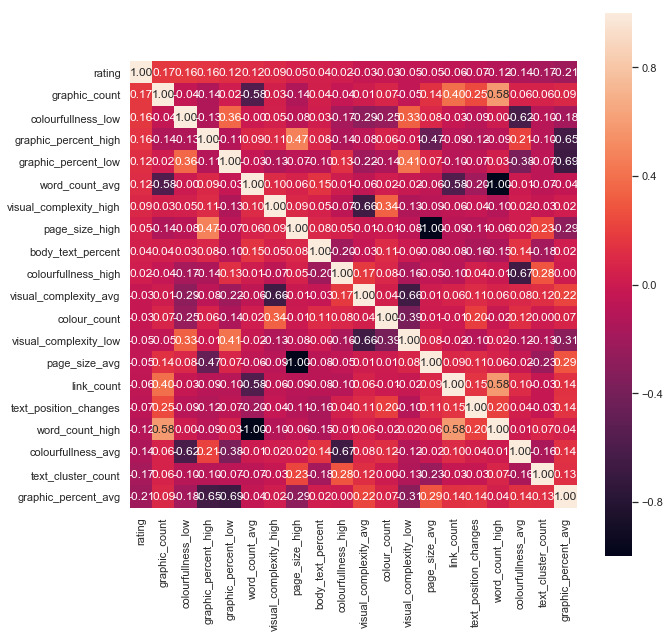

In [135]:
fig, ax = plt.subplots(figsize=(10,10))    
correlation_map = np.corrcoef(data[columns].values.T)
sns.set(font_scale=1)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f',yticklabels=columns.values, xticklabels=columns.values)
plt.savefig('corr.png')
#plt.show()


In [136]:
columns=columns.tolist()
#columns=columns[:3]+columns[-2:]
columns=pd.Index(columns)

In [137]:
Y=data['rating'].values
X_temp=data[columns]
X_temp.drop(['rating'],1, inplace=True)
X=X_temp.values

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [138]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle='True',test_size=0.3, random_state=1)

In [139]:
def LinearReg():
    from sklearn.linear_model import LinearRegression
    reg =LinearRegression()
    return reg
def RidgeReg():
    from sklearn.linear_model import Ridge
    reg =Ridge()
    return reg
def MLPReg():
    from sklearn.neural_network import MLPRegressor
    reg=MLPRegressor(hidden_layer_sizes=(50,),activation='logistic',solver='adam', max_iter=10000,batch_size=20,)
    return reg
def RMS_test(reg):
    from sklearn.metrics import mean_squared_error
    Y_pred=reg.predict(X_test)
    return Y_pred,mean_squared_error(Y_test, Y_pred)
def RMS_train(reg):
    from sklearn.metrics import mean_squared_error
    Y_pred=reg.predict(X_train)
    return mean_squared_error(Y_train, Y_pred)


In [140]:
regLinear=LinearReg()
regLinear.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [141]:
regRidge=RidgeReg()
regRidge.fit(X_train,Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [142]:
regMLP=MLPReg()
regMLP.fit(X_train,Y_train)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size=20, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [143]:
train=[RMS_train(regLinear),RMS_train(regRidge),RMS_train(regMLP)]
test=[RMS_test(regLinear),RMS_test(regRidge),RMS_test(regMLP)]



In [144]:
for i in zip(test,train):
    print(i)

((array([4.32935192, 4.56411416, 4.08231519, 3.91235464, 4.55772503,
       5.454951  , 4.24002865, 3.43975286, 4.27577084, 4.70464476,
       4.36129279, 4.371094  , 4.44369846, 4.53724539, 4.26860164,
       4.48991328, 4.69767507, 4.28048428, 4.36732753, 4.71191479,
       4.48692496, 4.54661003, 3.49972272, 4.40006985, 5.16250644,
       4.74669701, 4.25614601, 4.28484135, 4.51986521]), 0.7725108244299226), 0.5534691463760975)
((array([4.32767484, 4.60251118, 4.07717712, 3.93045826, 4.5496931 ,
       5.39462098, 4.23273638, 3.5711999 , 4.38939099, 4.69795928,
       4.3692499 , 4.46746817, 4.43060905, 4.562011  , 4.31506333,
       4.51569319, 4.63706869, 4.38855449, 4.46237623, 4.66359928,
       4.51923129, 4.63432156, 3.73002506, 4.39728476, 5.06896103,
       4.75117192, 4.25890537, 4.366355  , 4.5348556 ]), 0.7442016606487286), 0.5556961253608607)
((array([4.27998276, 4.53376451, 3.9911074 , 3.94835323, 4.46293992,
       5.14668718, 4.27273287, 3.82094846, 4.47768376, 4.7326

In [145]:
RMS_test(regLinear)[0]-Y_test

array([-0.92064808,  0.73078082, -0.13507611,  0.24568797, -0.4006083 ,
        0.22767828, -0.62953657, -1.16894279,  0.9424375 , -0.16492046,
       -0.42131591, -0.79557267, -0.12151893,  1.53724539,  0.6852683 ,
       -0.05175339, -0.7189916 , -0.71951572,  0.76732753, -0.62141854,
        0.660838  ,  1.41617525, -3.04194395,  0.40006985, -0.17082689,
       -0.58663633,  0.25614601,  0.19788483, -0.21926523])

In [146]:
for tup in zip(columns[1:],regLinear.coef_):
    print(tup)

('graphic_count', 0.30430697015078556)
('colourfullness_low', 0.35425298623700296)
('graphic_percent_high', -0.17622291148177854)
('graphic_percent_low', 0.35767037347263214)
('word_count_avg', 0.21953834228812505)
('visual_complexity_high', 0.2703451029637515)
('page_size_high', 0.19402646781953736)
('body_text_percent', 0.014268220654101774)
('colourfullness_high', -0.05755708846523308)
('visual_complexity_avg', 0.243825585121402)
('colour_count', 0.0594597847591124)
('visual_complexity_low', -0.5141706880851529)
('page_size_avg', -0.19402646781953753)
('link_count', -0.03904815293347955)
('text_position_changes', -0.06240962693994187)
('word_count_high', -0.2195383422881247)
('colourfullness_avg', -0.29669589777176975)
('text_cluster_count', -0.15254435071177938)
('graphic_percent_avg', -0.18144746199085376)


In [147]:
df={}
for year in range(2000,2020):
    df[str(year)]=pd.read_csv('yearMetrics/tempMpUrlMetrics'+str(year)+'.csv')
    df[str(year)]=dropMetrics(df[str(year)])
    df[str(year)]=preProcess(df[str(year)],mean,std)



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [148]:
columns[1:]

Index(['graphic_count', 'colourfullness_low', 'graphic_percent_high',
       'graphic_percent_low', 'word_count_avg', 'visual_complexity_high',
       'page_size_high', 'body_text_percent', 'colourfullness_high',
       'visual_complexity_avg', 'colour_count', 'visual_complexity_low',
       'page_size_avg', 'link_count', 'text_position_changes',
       'word_count_high', 'colourfullness_avg', 'text_cluster_count',
       'graphic_percent_avg'],
      dtype='object')

In [149]:
meanYears=np.zeros(20)
stdYears=np.zeros(20)
for year in range(2000,2020):
    meanYears[year-2000]=np.mean(regMLP.predict(df[str(year)][columns[1:]].values))
    stdYears[year-2000]=np.std(regMLP.predict(df[str(year)][columns[1:]].values))

In [150]:
regLinear.predict(df[str(2017)][columns[1:]].values),regLinear.coef_,columns[1:]

(array([4.4595764 , 3.95197388, 4.79144078, 4.47680176, 4.31173958,
        3.43189536, 4.3661519 , 4.04519887, 4.33548134, 4.31059831,
        5.24160288, 4.33333233, 4.35910025, 4.81927344, 4.1977415 ,
        4.85059544, 4.52500312, 4.685345  , 3.62534806, 5.29400281,
        3.78212619, 4.01373121, 4.63887279, 3.51093124, 4.07575365,
        4.21436306, 4.02679046, 4.20660918, 5.06543288, 4.33235206,
        4.1015648 , 3.55141364, 4.94830935, 4.49941855, 4.1675906 ,
        4.04195995, 4.90246768, 4.07342173, 4.49852204, 4.61400466,
        4.64448752, 3.57812457, 4.54221525, 3.3879666 , 4.46105656,
        3.86541039, 4.11758692, 3.86541039, 4.11758692, 4.79441168,
        4.37275686, 3.42041362, 4.27016859, 4.01062499, 5.20152944,
        3.72449032, 4.12387144, 4.42335156, 5.11322476, 4.33602946,
        4.15381902, 4.62644472, 4.65676318, 4.24088772, 4.73665899,
        4.84936409, 5.8554766 , 3.65985314, 4.1364985 , 4.09136782,
        5.85966476, 3.65985314, 4.52860552, 5.45

In [151]:
meanYears,stdYears

(array([4.03007633, 4.09370775, 4.12821813, 4.12998443, 4.16897545,
        4.20632997, 4.13941982, 4.18089278, 4.15576951, 4.19171838,
        4.2393682 , 4.28528035, 4.32301084, 4.37418425, 4.34594592,
        4.35883211, 4.31593252, 4.35463364, 4.34190879, 4.31792955]),
 array([0.23570154, 0.22918446, 0.25594905, 0.21836034, 0.25378466,
        0.25049143, 0.24833547, 0.2466786 , 0.25954188, 0.31372336,
        0.28059091, 0.29108107, 0.29865973, 0.29267996, 0.30214412,
        0.29203258, 0.32803643, 0.321138  , 0.3339036 , 0.27840561]))

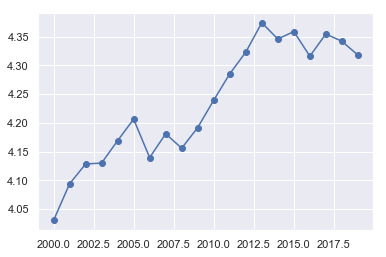

In [154]:
x=range(2000,2020)
y=meanYears
e=stdYears*0
plt.errorbar(x, y, e, fmt='-o')
plt.show()